In [2]:
# 0) Imports & seeds
import os, random, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D,
    SpatialDropout1D, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate, Dense, Dropout, Layer)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
plt.rcParams['figure.dpi'] = 120


In [3]:
# 1) Load & prepare data
# Expecting the file 'population_splits.pkl' in the working directory.
df = pd.read_pickle('population_splits.pkl')

def tag(df_in, val):
    x = df_in.copy()
    x['TIS'] = val  # 1 for true TIS, 0 for non-TIS
    return x

# Build a combined dataframe with an explicit TIS label
parts = [
    tag(df['Train']['Positive'], 1),
    tag(df['Train']['Negative'], 0),
    tag(df['Validation']['Positive'], 1),
    tag(df['Validation']['Negative'], 0),
    tag(df['Test']['Positive'], 1),
    tag(df['Test']['Negative'], 0)
]
combined_df = pd.concat(parts, ignore_index=True)

print('Combined size:', len(combined_df))
print('Columns:', list(combined_df.columns))
print(combined_df[['Transcript','Start Codon','TIS']].head())


Combined size: 52016
Columns: ['Transcript', 'Gene Name', 'Chrom', 'Strand', 'Location on Transcript', 'Start Codon', 'Transcript Index', 'Coordinate', 'Label', 'Genomic idx', 'Sequence', 'One Hot Encoding', 'Input Sequence Center Codon', 'Binary Label', 'TIS']
       Transcript Start Codon  TIS
0  XM_005258465.6         ATG    1
1  XM_011526394.4         ATG    1
2     NM_005765.3         CTG    1
3     NM_005765.3         ATG    1
4  XM_017029594.3         ATG    1


In [4]:
# 2) Mask center triplet & build inputs
def mask_center_codon(one_hot_array):
    arr = np.array(one_hot_array)
    center = len(arr) // 2
    arr[center-1:center+2] = 0
    return arr

combined_df['Input'] = combined_df['One Hot Encoding'].apply(mask_center_codon)

# Codon label (for adversarial task)
le = LabelEncoder()
combined_df['CodonID'] = le.fit_transform(combined_df['Start Codon'].astype(str))
num_codons = len(le.classes_)
print('Codon classes:', le.classes_)


Codon classes: ['AAG' 'ACG' 'AGG' 'ATA' 'ATC' 'ATG' 'ATT' 'CTG' 'GTG' 'TTG']


In [5]:
# 3) Transcript-level split to avoid leakage
transcripts = combined_df['Transcript'].astype(str).unique()
train_ids, test_ids = train_test_split(transcripts, test_size=0.2, random_state=seed)

train_df = combined_df[combined_df['Transcript'].astype(str).isin(train_ids)].copy()
test_df  = combined_df[combined_df['Transcript'].astype(str).isin(test_ids)].copy()

X_train = np.stack(train_df['Input'].values)
y_tis_train = train_df['TIS'].values.astype(np.float32)
y_codon_train = tf.keras.utils.to_categorical(train_df['CodonID'].values, num_classes=num_codons)

X_test = np.stack(test_df['Input'].values)
y_tis_test = test_df['TIS'].values.astype(np.float32)
y_codon_test = tf.keras.utils.to_categorical(test_df['CodonID'].values, num_classes=num_codons)

print('Train/Test shapes:', X_train.shape, X_test.shape)


Train/Test shapes: (41749, 703, 4) (10267, 703, 4)


In [6]:
# 4) Gradient Reversal Layer (adversarial)
class GradientReversal(Layer):
    def __init__(self, lambd=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambd = tf.constant(lambd, dtype=tf.float32)
    def call(self, x):
        @tf.custom_gradient
        def _flip(x):
            def grad(dy):
                return -self.lambd * dy
            return x, grad
        return _flip(x)

def build_model(input_shape, num_codons, grl_lambda=1.0):
    inp = Input(shape=input_shape)
    x = Conv1D(128, 7, padding='same')(inp); x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.15)(x)
    x = Conv1D(96, 5, padding='same', dilation_rate=2)(x); x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.15)(x)
    x = Conv1D(64, 3, padding='same', dilation_rate=4)(x); x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.15)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    gmax = GlobalMaxPooling1D()(x); gavg = GlobalAveragePooling1D()(x)
    z = Concatenate()([gmax, gavg])
    z = Dense(128, activation='relu')(z); z = Dropout(0.5)(z)

    # Main TIS head
    tis = Dense(1, activation='sigmoid', name='tis')(z)

    # Adversarial codon head via GRL
    rev = GradientReversal(lambd=grl_lambda)(z)
    codon = Dense(128, activation='relu')(rev)
    codon = Dropout(0.3)(codon)
    codon = Dense(num_codons, activation='softmax', name='codon')(codon)

    model = Model(inp, [tis, codon])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss={'tis':'binary_crossentropy','codon':'categorical_crossentropy'},
        metrics={'tis':[AUC(name='auc')],'codon':['accuracy']},
        loss_weights={'tis':1.0,'codon':1.0}
    )
    return model

model = build_model(X_train.shape[1:], num_codons=num_codons, grl_lambda=1.0)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 703, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 703, 128)  │      3,712 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 703, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 703, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 351, 128)  │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 351, 128)  │          0 │ max_pooling1d[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 351, 96)   │     61,536 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 351, 96)   │        384 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 351, 96)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 175, 96)   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 175, 96)   │          0 │ max_pooling1d_1[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 175, 64)   │     18,496 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 175, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 87, 64)    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 87, 64)    │          0 │ max_pooling1d_2[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 87, 128)   │     66,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional[0]

 Total params: 201,771 (788.17 KB)

 Trainable params: 201,195 (785.92 KB)

 Non-trainable params: 576 (2.25 KB)

In [7]:
# 5) Train
early = EarlyStopping(monitor='val_tis_auc', mode='max', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_tis_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train,
    {'tis': y_tis_train, 'codon': y_codon_train},
    validation_split=0.1,
    epochs=40,
    batch_size=128,
    callbacks=[early, rlr],
    verbose=1
)


Epoch 1/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - codon_accuracy: 0.1371 - codon_loss: 2.9505 - loss: 3.5481 - tis_auc: 0.5100 - tis_loss: 0.5976 - val_codon_accuracy: 0.1921 - val_codon_loss: 2.2004 - val_loss: 2.4360 - val_tis_auc: 0.5000 - val_tis_loss: 0.2336 - learning_rate: 0.0010
Epoch 2/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 61s 206ms/step - codon_accuracy: 0.1882 - codon_loss: 2.2090 - loss: 2.5732 - tis_auc: 0.5056 - tis_loss: 0.3643 - val_codon_accuracy: 0.1921 - val_codon_loss: 2.1818 - val_loss: 2.4138 - val_tis_auc: 0.5412 - val_tis_loss: 0.2298 - learning_rate: 0.0010
Epoch 3/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - codon_accuracy: 0.1956 - codon_loss: 2.1793 - loss: 2.5446 - tis_auc: 0.4999 - tis_loss: 0.3653 - val_codon_accuracy: 0.1921 - val_codon_loss: 2.1779 - val_loss: 2.4112 - val_tis_auc: 0.5087 - val_tis_loss: 0.2310 - learning_rate: 0.0010
Epoch 4/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - codon_accuracy: 0.1981 - codon_loss: 2.1689 - loss: 2.5326

Test TIS AUROC: 0.780
Codon-head accuracy: 0.210 (random baseline ~0.100)


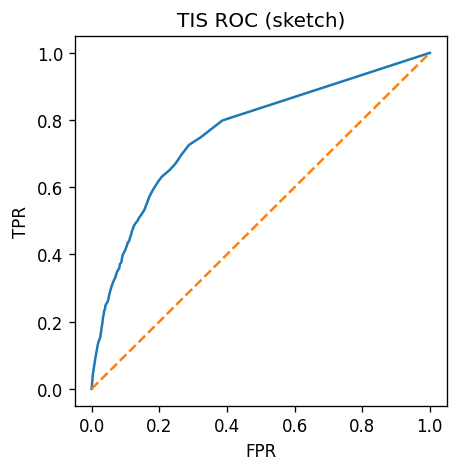

In [9]:
# 6) Evaluate on held-out transcripts
y_tis_pred_test, y_codon_pred_test = model.predict(X_test, verbose=0)
y_tis_pred_test = y_tis_pred_test.ravel()
tis_auc = roc_auc_score(y_tis_test, y_tis_pred_test)
codon_acc = accuracy_score(np.argmax(y_codon_test,1), np.argmax(y_codon_pred_test,1))
rand_acc = 1.0 / num_codons
print(f"Test TIS AUROC: {tis_auc:.3f}")
print(f"Codon-head accuracy: {codon_acc:.3f} (random baseline ~{rand_acc:.3f})")

# Simple diagnostic plot: ROC-like threshold sweep (not full ROC curve)
ths = np.linspace(0,1,101)
tpr = [( (y_tis_pred_test>=t) & (y_tis_test==1) ).sum() / max(1,(y_tis_test==1).sum()) for t in ths]
fpr = [( (y_tis_pred_test>=t) & (y_tis_test==0) ).sum() / max(1,(y_tis_test==0).sum()) for t in ths]
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('TIS ROC (sketch)'); plt.show()


Mean saliency peak at position: 351 | Center: 351


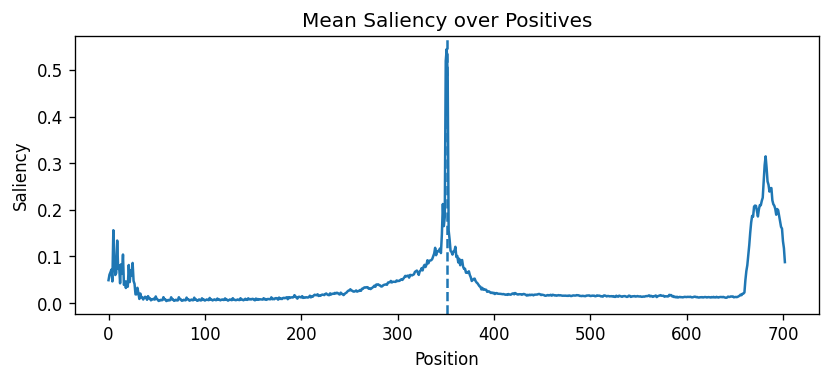

In [10]:
# 7) Saliency utilities & visualization
def compute_saliency(model, x):
    # gradients wrt input for the TIS head only
    inp = tf.convert_to_tensor(x[None], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(inp)
        y_tis, _ = model(inp, training=False)
    grads = tape.gradient(y_tis, inp).numpy()[0]
    sal = np.abs(grads).sum(axis=-1)  # sum over channels
    return sal

# Compute average saliency over N positive test examples
pos_idx = np.where(y_tis_test==1)[0]
N = min(200, len(pos_idx))
sel = np.random.choice(pos_idx, size=N, replace=False) if len(pos_idx)>0 else []
if len(sel)>0:
    S = np.stack([compute_saliency(model, X_test[i]) for i in sel])
    mean_sal = S.mean(axis=0)
    peak = int(np.argmax(mean_sal))
    center = X_test.shape[1]//2
    print('Mean saliency peak at position:', peak, '| Center:', center)

    plt.figure(figsize=(8,3))
    plt.plot(mean_sal)
    plt.axvline(center, linestyle='--')
    plt.title('Mean Saliency over Positives')
    plt.xlabel('Position'); plt.ylabel('Saliency')
    plt.show()
else:
    print('No positive examples in test set to compute saliency.')


[ATG] TIS vs decoy set → N=2962 (positives=2643, negatives=319)
→ Running: No Mask
   AUROC = 0.642
→ Running: Partial codon masked
   AUROC = 0.628
→ Running: Full codon masked
   AUROC = 0.605
→ Running: Upstream masked (10nt)
   AUROC = 0.642
→ Running: Downstream masked (10nt)
   AUROC = 0.706


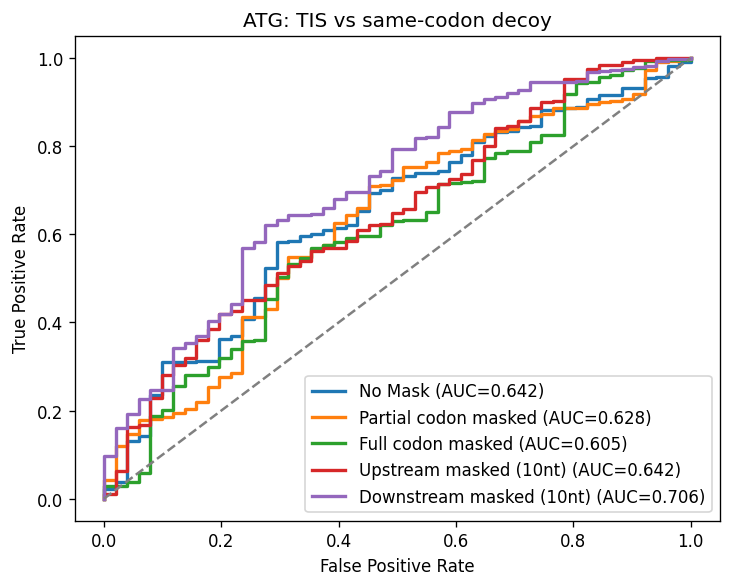

In [ ]:
# --- Multi-masking TIS vs same-codon decoy experiment -----------------------
# Works with your combined_df DataFrame created from population_splits.pkl.
# Pip: tensorflow, scikit-learn, numpy, pandas, matplotlib required.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping

CODON = "ATG"            # which codon to analyze
MASK_BACKGROUND = "empirical"   # "empirical" or "uniform"
UPSTREAM_WIN = 10        # for asymmetric upstream mask (nt before codon)
DOWNSTREAM_WIN = 10      # for asymmetric downstream mask (nt after codon)
CENTER_TRIPLET_IS_MIDDLE = True  # if True, codon is at indices L//2-1 : L//2+2

np.random.seed(1337)
tf.random.set_seed(1337)

# -----------------------------------------------------------
# 1) UTIL – detect label column, get background freqs, helpers
# -----------------------------------------------------------
def detect_label_column(df):
    candidates = ["Is_TIS", "Binary Label", "Label"]
    for c in candidates:
        if c in df.columns:
            vals = pd.Series(df[c]).dropna().unique()
            try:
                s = set(int(v) for v in vals)
            except Exception:
                continue
            if s.issubset({0,1}):
                return c
    raise ValueError(
        "Could not find a binary true/false TIS label column among ['Is_TIS','Binary Label','Label']."
    )

def get_center_indices(L):
    # returns (start, end) index of the codon in the one-hot array
    # our convention matches your earlier code: center-1:center+2
    center = L // 2
    return center-1, center+2  # [start:end]

def onehot_to_basefreq(arr_list):
    """ Empirical base frequencies A,C,G,T from a list of (L,4) arrays. """
    total = np.zeros(4, dtype=np.float64)
    npos = 0
    for a in arr_list:
        A = np.asarray(a)
        if A.ndim != 2 or A.shape[1] != 4:
            continue
        total += A.sum(axis=0)
        npos += A.shape[0]
    if total.sum() == 0:
        return np.array([0.25,0.25,0.25,0.25], dtype=np.float64)
    return total / total.sum()

def mask_positions(arr, pos_slice, fill_vec):
    """ In-place: arr[pos_slice] = fill_vec """
    arr = arr.copy()
    arr[pos_slice] = fill_vec
    return arr

def mask_window(arr, start, end, fill_vec):
    arr = arr.copy()
    arr[start:end] = fill_vec
    return arr

def add_positional_channels(arr):
    """ Append 2 positional channels (fractional index, reverse fractional). """
    L = arr.shape[0]
    pos1 = np.linspace(0, 1, L)[:, None]
    pos2 = np.linspace(1, 0, L)[:, None]
    return np.concatenate([arr, pos1, pos2], axis=-1)

# -----------------------------------------------------------
# 2) BUILD controlled dataset: true TIS vs same-codon decoys
# -----------------------------------------------------------
def build_tis_vs_decoy_df(df, codon, label_col, max_decoys_per_pos=2):
    """
    Positives: true TIS rows for codon.
    Negatives: rows with SAME codon in SAME transcript but label=0.
    Balances per transcript to avoid trivial biases.
    """
    df = df.copy()
    df = df[df["Start Codon"] == codon].copy()

    pos = df[df[label_col] == 1]
    neg = df[df[label_col] == 0]
    if len(pos) == 0:
        raise ValueError(f"No positives found for codon {codon}.")

    # Group negatives by transcript for controlled sampling
    neg_by_tx = defaultdict(list)
    for i, r in neg.iterrows():
        neg_by_tx[r["Transcript"]].append(i)

    keep_idx = []
    for tx, grp in pos.groupby("Transcript"):
        keep_idx.extend(grp.index.tolist())
        pool = neg_by_tx.get(tx, [])
        if len(pool) > 0:
            # sample up to K per positive
            K = min(len(pool), len(grp)*max_decoys_per_pos)
            keep_idx.extend(np.random.choice(pool, size=K, replace=False))

    sub = df.loc[keep_idx].sample(frac=1, random_state=1337).reset_index(drop=True)
    return sub

def get_fill_vector(background, mode="empirical"):
    if mode == "uniform":
        return np.array([0.25,0.25,0.25,0.25], dtype=np.float32)
    return background.astype(np.float32)

def mask_full_codon(seq, fill_vec):
    L = seq.shape[0]
    c0, c1 = get_center_indices(L)
    return mask_positions(seq, slice(c0, c1), fill_vec)

def mask_partial_codon(seq, fill_vec):
    L = seq.shape[0]
    c0, c1 = get_center_indices(L)
    return mask_positions(seq, slice(c0+1, c1), fill_vec)

def mask_asymmetric_upstream(seq, fill_vec, win=10):
    L = seq.shape[0]
    c0, _ = get_center_indices(L)
    start = max(0, c0 - win)
    return mask_window(seq, start, c0, fill_vec)

def mask_asymmetric_downstream(seq, fill_vec, win=10):
    L = seq.shape[0]
    _, c1 = get_center_indices(L)
    end = min(L, c1 + win)
    return mask_window(seq, c1, end, fill_vec)

def make_inputs(sub_df, masking="none", fill_vec=None):
    """
    masking ∈ {"none", "full_codon", "partial_codon", "upstream", "downstream"}
    Returns X (N, L, 6) → 4 bases + 2 pos channels
    """
    X = []
    for seq in sub_df["One Hot Encoding"].values:
        S = np.asarray(seq, dtype=np.float32)
        if masking == "full_codon":
            S = mask_full_codon(S, fill_vec)
        elif masking == "partial_codon":
            S = mask_partial_codon(S, fill_vec)
        elif masking == "upstream":
            S = mask_asymmetric_upstream(S, fill_vec, win=UPSTREAM_WIN)
        elif masking == "downstream":
            S = mask_asymmetric_downstream(S, fill_vec, win=DOWNSTREAM_WIN)
        X.append(add_positional_channels(S))
    return np.stack(X, axis=0)

def build_cnn(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(128, 7, padding="same")(inp); x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Conv1D(64, 5, padding="same")(x);   x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Conv1D(32, 3, padding="same")(x);   x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x); x = Dropout(0.4)(x)
    x = Dense(64,  activation="relu")(x); x = Dropout(0.3)(x)
    out = Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

def run_mode(sub_df, label_col, masking, fill_vec, epochs=8, batch=128):
    # Split by transcript to avoid leakage
    tx = sub_df["Transcript"].values
    uniq_tx = np.unique(tx)
    tr_tx, te_tx = train_test_split(uniq_tx, test_size=0.2, random_state=1337)
    train_df = sub_df[sub_df["Transcript"].isin(tr_tx)].copy()
    test_df  = sub_df[sub_df["Transcript"].isin(te_tx)].copy()

    X_train = make_inputs(train_df, masking, fill_vec)
    X_test  = make_inputs(test_df, masking, fill_vec)
    y_train = train_df[label_col].values.astype(np.float32)
    y_test  = test_df[label_col].values.astype(np.float32)

    model = build_cnn(X_train.shape[1:])
    es = EarlyStopping(patience=2, restore_best_weights=True, monitor="val_loss")
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, batch_size=batch, verbose=0, callbacks=[es])

    y_pred = model.predict(X_test, verbose=0).ravel()
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    return {"auc": auc, "fpr": fpr, "tpr": tpr, "pred": y_pred, "y": y_test}

def multi_masking_study(combined_df, codon=CODON, include_no_mask=True):
    label_col = detect_label_column(combined_df)
    # restrict to rows that contain a one-hot and the desired codon
    valid = combined_df.dropna(subset=["One Hot Encoding"])
    valid = valid[valid["Start Codon"] == codon].copy()

    # build controlled TIS vs decoy dataset
    sub = build_tis_vs_decoy_df(valid, codon, label_col, max_decoys_per_pos=2)
    print(f"[{codon}] TIS vs decoy set → N={len(sub)} (positives={sub[label_col].sum()}, "
          f"negatives={len(sub)-sub[label_col].sum()})")

    # empirical base frequencies (for degenerate masking)
    bg = onehot_to_basefreq(sub["One Hot Encoding"].values)
    fill_vec = get_fill_vector(bg, mode=MASK_BACKGROUND)

    modes = []
    if include_no_mask:
        modes.append(("no_mask", "No Mask"))
    modes.extend([
        ("partial_codon", "Partial codon masked"),
        ("full_codon",    "Full codon masked"),
        ("upstream",      f"Upstream masked ({UPSTREAM_WIN}nt)"),
        ("downstream",    f"Downstream masked ({DOWNSTREAM_WIN}nt)"),
    ])

    results = {}
    for key, label in modes:
        print(f"→ Running: {label}")
        res = run_mode(sub, label_col, masking=(key if key!="no_mask" else "none"), fill_vec=fill_vec)
        results[key] = (label, res["auc"], res["fpr"], res["tpr"])
        print(f"   AUROC = {res['auc']:.3f}")

    plt.figure(figsize=(6.2,5.0))
    for key,(label,auc,fpr,tpr) in results.items():
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], "--", color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{codon}: TIS vs same-codon decoy")
    plt.legend()
    plt.tight_layout()
    plt.show()


    return results

results = multi_masking_study(combined_df, codon=CODON, include_no_mask=True)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import spearmanr

def _get_preds(model, X, key=None):
    """Return flat prediction vector from a Keras model (dict or array)."""
    out = model.predict(X, verbose=0)
    if isinstance(out, dict):
        if key is not None and key in out:
            return out[key].ravel()
        # pick the first head if no key is supplied
        first = next(iter(out.keys()))
        return out[first].ravel()
    return np.asarray(out).ravel()

def _is_binary(y):
    u = np.unique(y)
    return set(u).issubset({0,1})

def _mask_window(seq_array, center, window_size=3):
    """Mask a window in one-hot sequence (L,4) by replacing with uniform 0.25."""
    seq_copy = seq_array.copy()
    start = max(center - window_size, 0)
    end   = min(center + window_size + 1, seq_array.shape[0])
    seq_copy[start:end, :] = 0.25
    return seq_copy

def positional_ablation_heatmap(
    model, X, y,
    window_size=3,
    head_key=None,                  # set if your model has multiple heads, e.g., 'y_bin'
    binarize_quantile=0.5,          # only used for regression labels
    title_prefix="Positional Ablation",
):
    """
    Slide a masking window across positions; plot Δ metric vs baseline.
    - If y is binary: metric = AUROC.
    - If y is continuous: metric = Spearman ρ, and a proxy AUROC is computed
      by binarizing y at the given quantile for plotting convenience.
    """
    X = np.asarray(X)
    y = np.asarray(y)

    # ----- baseline predictions
    preds = _get_preds(model, X, head_key)

    L = X.shape[1]
    mask = ~np.isnan(y)
    Xm, ym, pm = X[mask], y[mask], preds[mask]

    # ----- choose metric(s)
    if _is_binary(ym):
        # Binary classification: AUROC baseline
        try:
            baseline_metric = roc_auc_score(ym, pm)
            metric_name = "AUROC"
        except ValueError:
            # fall back if degenerate
            baseline_metric = average_precision_score(ym, pm)
            metric_name = "AUPRC"
        # Function to compute masked metric
        def compute_metric(pred, y_true):
            try:
                return roc_auc_score(y_true, pred)
            except ValueError:
                return average_precision_score(y_true, pred)
    else:
        # Regression: report Spearman and create proxy AUROC via binarization
        rho, _ = spearmanr(ym, pm)
        metric_name = f"Spearman ρ (baseline={rho:.3f})"
        # For heat map values, binarize y by quantile (median by default)
        thr = np.quantile(ym, binarize_quantile)
        y_bin = (ym >= thr).astype(int)
        try:
            baseline_metric = roc_auc_score(y_bin, pm)
            metric_name_for_heat = f"AUROC (bin q={binarize_quantile:.2f})"
        except ValueError:
            baseline_metric = average_precision_score(y_bin, pm)
            metric_name_for_heat = f"AUPRC (bin q={binarize_quantile:.2f})"
        # Replace ym with y_bin for heatmap metric
        ym = y_bin
        def compute_metric(pred, y_true):
            try:
                return roc_auc_score(y_true, pred)
            except ValueError:
                return average_precision_score(y_true, pred)
        # Also show Spearman in the title later
    # ----- sweep positions
    metrics_per_pos = []
    for pos in range(L):
        X_masked = np.array([_mask_window(seq, pos, window_size) for seq in Xm])
        pm_mask = _get_preds(model, X_masked, head_key)
        m = compute_metric(pm_mask, ym)
        metrics_per_pos.append(m)
    metrics_per_pos = np.array(metrics_per_pos)
    delta = metrics_per_pos - baseline_metric

    # ----- plot heatmap
    vmax = np.max(np.abs(delta)) if np.isfinite(delta).any() else 0.0
    vmax = max(vmax, 1e-6)

    plt.figure(figsize=(12, 4))
    plt.imshow(delta[np.newaxis, :], cmap="bwr", aspect="auto",
               vmin=-vmax, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label(f"Δ {('AUROC' if _is_binary(y) else metric_name_for_heat)} vs baseline")
    plt.title(f"{title_prefix} (window ±{window_size} nt) — baseline {metric_name}: {baseline_metric:.3f}")
    plt.xlabel("Position (nt)")
    plt.yticks([])
    plt.show()

    return baseline_metric, metrics_per_pos, delta


In [37]:
# y_test must be 0/1
baseline, prof, delta = positional_ablation_heatmap(
    model, X_test, y_test, window_size=3, head_key=None,
    title_prefix="[ATG] TIS vs Decoy"
)


KeyboardInterrupt: 